In [1]:
library(IRdisplay)
library(Cairo)

library(ggplot2)
library(dplyr)
library(ggrepel)
library(data.table)
library(cowplot)
library(tidyr)
library(biomaRt)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package:

In [2]:
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

In [3]:
LINESIZE = 1
FONTSIZE = 12
THEME = theme_cowplot(font_size = FONTSIZE, font_family = 'Helvetica') + theme(plot.tag = element_text(face = "bold"))

In [4]:
output_path = '/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots'

In [5]:
result_path = '/s/project/promoter_prediction/sex_analysis/isoform_proportions'
result_interaction_path = '/s/project/promoter_prediction/sex_analysis/inter_isoform_proportions'

In [6]:
inter_rds_files = list.files(path = result_interaction_path, pattern = "\\.RDS$", full.names = TRUE)

In [7]:
rds_files = list.files(path = result_path, pattern = "\\.RDS$", full.names = TRUE)

In [8]:
length(rds_files)

[1] 8790

In [9]:
length(inter_rds_files)     

[1] 8790

In [10]:
extract_gene_name <- function(file) {
  # Extract the base name of the file (without path)
  file_base <- basename(file)
  # Use regular expression to extract the gene name (assuming the gene name is before the first dot)
  gene_name <- sub(".RDS$", "", file_base)
  return(gene_name)
}

In [11]:
names(rds_files) <- sapply(rds_files, extract_gene_name)
names(inter_rds_files) <- sapply(inter_rds_files, extract_gene_name)

In [12]:
gene_symbol_map = getBM(attributes = c('ensembl_gene_id', 'hgnc_symbol'),
                   filters = 'ensembl_gene_id',
                   values = names(rds_files),
                   mart = ensembl)

In [13]:
names(gene_symbol_map)[1] = 'gene'

In [14]:
extract_inter_values <- function(file) {
    rds_data <- readRDS(file)
    modelCoefs <- rds_data$sexModelCoef$beta
    coefMatrix <- sapply(modelCoefs[2:length(modelCoefs)], function(x) x[grep(":sexMale$", names(x))])
    abs_max_score <- max(abs(coefMatrix))
    position <- which(abs(coefMatrix) == abs_max_score, arr.ind = TRUE)
    tissue <- rownames(coefMatrix)[position[1, "row"]] %>% sub('tissue', '', .)  %>% sub(':sexMale', '', .)
    transcript <- colnames(coefMatrix)[position[1, "col"]] %>% sub('proportion_', '', .)
    signed_max_score <- coefMatrix[position[1, "row"], position[1, "col"]]
    pval = rds_data$anovaRes$`Pr(>Chi)`[2]             
    return(list(tissue=tissue, transcript=transcript, signed_max_score=signed_max_score, pval=pval))     
}

In [15]:
extract_values <- function(file) {
    rds_data <- readRDS(file)
    anovaRes <- rds_data$anovaRes
    modelCoefs <- rds_data$sexModelCoef$beta
    modelCoefs <- sapply(modelCoefs[2:length(modelCoefs)], function(x) x[["sexMale"]])
    signedMaxCoef <- modelCoefs[which.max(abs(modelCoefs))]
    transcript = sub("proportion_", "", names(signedMaxCoef))
    signedMaxCoef <- unlist(signedMaxCoef)
    return(list(pvalue=anovaRes$`Pr(>Chi)`[2], signedMaxCoef=signedMaxCoef, transcript=transcript))
}

In [16]:
df = bind_rows(lapply(rds_files, extract_values), .id = "gene") %>% as.data.table()

In [17]:
# filter out genes that did not converge
df = df[pvalue != 0]
df$adjusted_pvalue <- p.adjust(df$pvalue, method = "BH")
df$negLog10Pvalue <- -log10(df$adjusted_pvalue)
df[, significance:='none']
df[adjusted_pvalue  <= 0.01 & abs(signedMaxCoef) > 0.1, significance := 'high']
df[adjusted_pvalue  <= 0.01 & abs(signedMaxCoef) < 0.1, significance := 'low']

In [18]:
significant_genes <- df[order(adjusted_pvalue), ][significance!='none', gene]

In [19]:
high_significant_genes <- df[order(adjusted_pvalue), ][significance=='high', gene]

In [20]:
length(significant_genes)

[1] 1490

In [21]:
length(high_significant_genes)

[1] 289

In [22]:
df_inter = bind_rows(lapply(inter_rds_files[names(inter_rds_files) %in% significant_genes], extract_inter_values), .id = "gene") %>% as.data.table()
head(df_inter)

gene,tissue,transcript,signed_max_score,pval
<chr>,<chr>,<chr>,<dbl>,<dbl>
ENSG00000001084,Lung,ENST00000510837,0.6114089,7.822415e-05
ENSG00000002549,Heart,ENST00000618908,-0.1878075,1.369247e-06
ENSG00000003056,Brain,ENST00000541507,-0.2211368,7.463101e-04
ENSG00000003402,Esophagus,ENST00000341222,-0.3895507,1.121179e-22
ENSG00000003436,Pancreas,ENST00000339091,0.6568679,6.283918e-09
ENSG00000003509,Brain,ENST00000474257,-0.3713289,3.744211e-07


In [23]:
dim(df_inter)

[1] 1490    5

In [24]:
df_inter[, num_tissue:=.N,by='tissue']
df_inter[, tissue_prop := num_tissue/.N]

In [25]:
tissue_info = df_inter[, .SD[1,.(tissue_prop, num_tissue)], by=tissue]
tissue_info

tissue,tissue_prop,num_tissue
<chr>,<dbl>,<int>
Lung,0.03825503,57
Heart,0.13825503,206
Brain,0.15838926,236
Esophagus,0.05436242,81
Pancreas,0.10738255,160
Colon,0.02617450,39
Blood,0.10067114,150
Breast,0.16442953,245
Thyroid,0.02751678,41


In [26]:
df = df[gene_symbol_map, on=.(gene)]

In [27]:
df_inter = df_inter[gene_symbol_map, on=.(gene), , nomatch = NULL]

In [28]:
df_inter[hgnc_symbol=='BCL6']

gene,tissue,transcript,signed_max_score,pval,num_tissue,tissue_prop,hgnc_symbol
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>
ENSG00000113916,Esophagus,ENST00000419510,0.3077953,1.11628e-19,81,0.05436242,BCL6


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


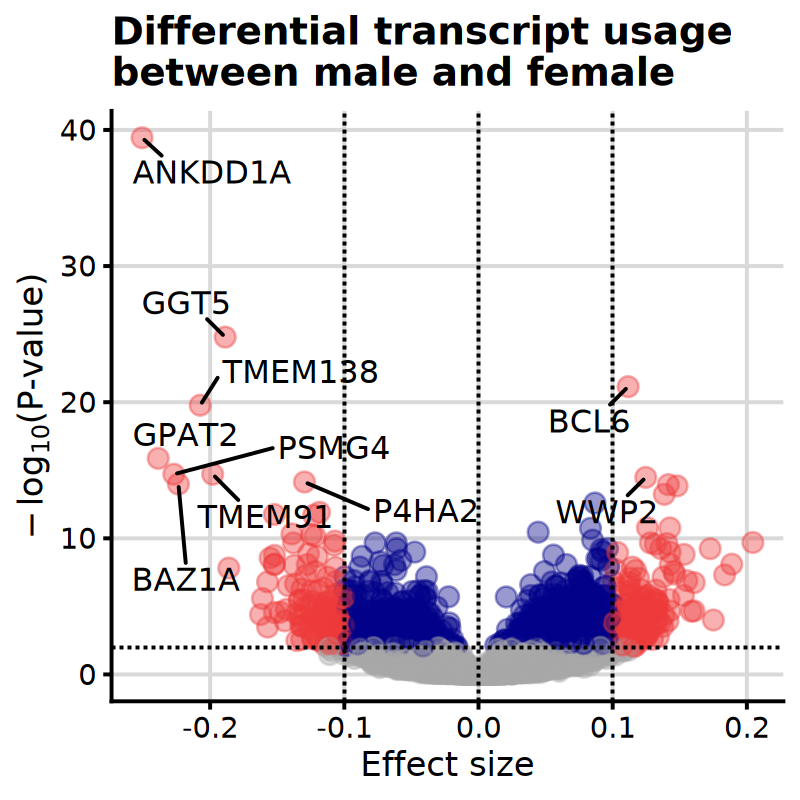

In [29]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=200)
# Sort dataframe by pvalue and select the top 5 genes
top5_genes <- df[gene %in% significant_genes[1:10], ]

# Create the volcano plot
p = ggplot(df, aes(x = `signedMaxCoef`, y = `negLog10Pvalue`)) +
  geom_point(alpha = 0.4, size = 3, aes(color = significance), show.legend = FALSE) +  # Scatter plot points
  scale_color_manual(values=c(none='darkgrey', high='brown2', low='darkblue'))+
  geom_vline(xintercept = 0, linetype = "dashed") +  # Vertical line at x = 0
  geom_vline(xintercept = 0.1, linetype = "dashed") +  # Vertical line at x = 0
  geom_vline(xintercept = -0.1, linetype = "dashed") +  # Vertical line at x = 0
  geom_hline(yintercept = -log10(0.01), linetype = "dashed") +  # Horizontal line for p = 0.01
  labs(title = "Differential transcript usage\nbetween male and female", x = "Effect size", 
       y = expression(paste(-log[10], "(P-value)", ))) +
  THEME + background_grid() +  # Minimal theme
  geom_text_repel(data = top5_genes, aes(label = hgnc_symbol), size = 4, box.padding = 0.5) + # Add labels for top 5 genes
  theme(legend.title=element_blank())
p

In [30]:
width=4
height=4

path = paste(output_path, 'sex_volcano', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/sex_volcano..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


## Most significant tissues

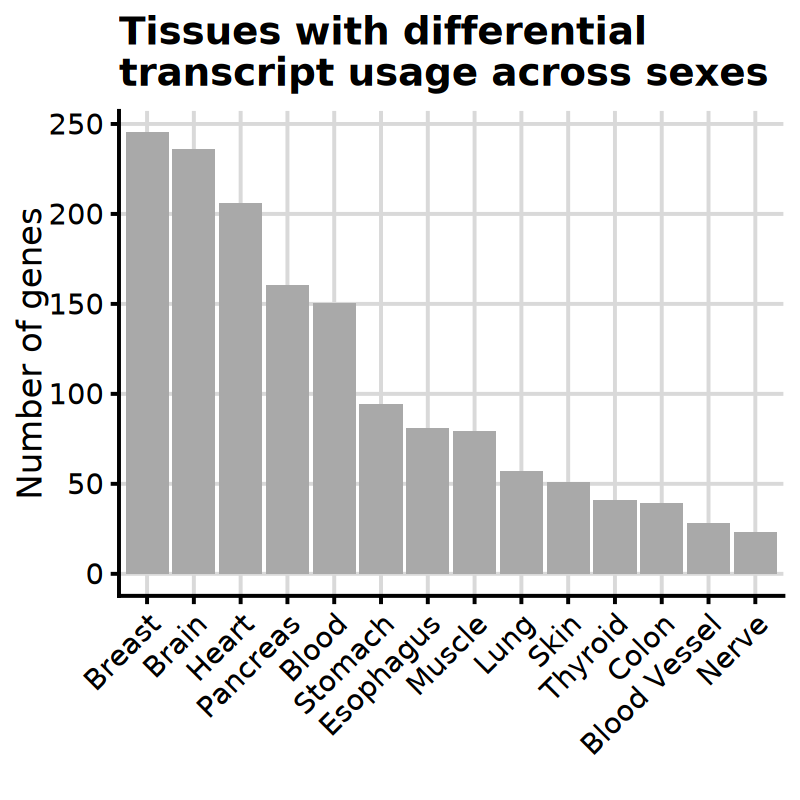

In [40]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=200)
p = ggplot(tissue_info, aes(x=reorder(tissue, num_tissue, decreasing = TRUE), y=num_tissue)) +
    geom_bar(stat = "identity", fill='darkgray') +
    THEME + background_grid() + theme(axis.text.x=element_text(angle=45, hjust = 1)) +
    labs(y='Number of genes', x='', title='Tissues with differential\ntranscript usage across sexes')
p

In [41]:
width=4
height=4

path = paste(output_path, 'sex_tissues', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/sex_tissues..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”


## Gene enrichment analysis

In [167]:
df_inter[tissue=='Breast', ][order(abs(signed_max_score), decreasing = TRUE)]

gene,tissue,transcript,signed_max_score,pval,num_tissue,tissue_prop
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
ENSG00000076662,Breast,ENST00000592439,1.2211325,9.761786e-20,145,0.1596916
ENSG00000137699,Breast,ENST00000524816,0.9132886,3.325488e-11,145,0.1596916
ENSG00000140525,Breast,ENST00000310775,-0.8883319,1.138017e-08,145,0.1596916
ENSG00000006047,Breast,ENST00000571834,-0.7940430,1.829903e-09,145,0.1596916
ENSG00000153064,Breast,ENST00000504403,-0.7635663,5.569888e-05,145,0.1596916
ENSG00000154153,Breast,ENST00000399793,-0.7237548,4.861601e-06,145,0.1596916
ENSG00000015133,Breast,ENST00000556726,-0.7150832,1.703563e-11,145,0.1596916
ENSG00000076554,Breast,ENST00000518937,-0.7024696,8.545957e-07,145,0.1596916
ENSG00000101019,Breast,ENST00000397554,-0.6846508,2.734535e-13,145,0.1596916


In [47]:
run_go <- function (tissue_val){
    entrez_info = getBM(attributes = c("ensembl_gene_id", "entrezgene_id"),
                       filters = "ensembl_gene_id",
                       values = df_inter[tissue==tissue_val, gene],
                       mart = ensembl)
    res = enrichGO(gene         = entrez_info$entrezgene_id, 
                              OrgDb        = org.Hs.eg.db, 
                              ont          = "BP",         # Use "MF" or "CC" for other categories
                              pAdjustMethod = "BH",        # Adjust for multiple testing
                              pvalueCutoff  = 0.05, 
                              qvalueCutoff  = 0.05,
                              readable      = TRUE)        # Convert Entrez IDs back to gene symbols
    res = as.data.frame(res)
    if(nrow(res) > 0){
        res$tissue = tissue_val    
    }
    return(res)
}

tissue_enrichments = lapply(unique(df_inter$tissue), run_go)

In [49]:
do.call(rbind, tissue_enrichments)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,tissue
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0016226,GO:0016226,iron-sulfur cluster assembly,3/52,30/18870,7.603028e-05,0.030830279,0.027130805,NUBP2/MMS19/BOLA3,3,Lung
GO:0031163,GO:0031163,metallo-sulfur cluster assembly,3/52,30/18870,7.603028e-05,0.030830279,0.027130805,NUBP2/MMS19/BOLA3,3,Lung
GO:0048193,GO:0048193,Golgi vesicle transport,14/195,294/18870,2.394006e-06,0.005752797,0.005410454,SPAST/ATP9A/AP3D1/SNAP23/GOSR1/COPA/KIF1C/GCC2/RER1/VCP/COMMD1/GAK/COPG1/SEC22B,14,Heart
GO:0048499,GO:0048499,synaptic vesicle membrane organization,5/195,28/18870,9.069024e-06,0.010896433,0.010247997,AP3D1/SNAP23/GRIK5/SYNGR2/PRRT2,5,Heart
GO:0007264,GO:0007264,small GTPase mediated signal transduction,7/37,491/18870,4.047921e-05,0.022956796,0.020423585,RHOBTB1/RAPGEF4/ARFGAP1/MADD/DOCK2/ITPKB/RALGAPB,7,Colon
GO:0043368,GO:0043368,positive T cell selection,3/37,40/18870,6.521817e-05,0.022956796,0.020423585,DOCK2/ITPKB/STAT6,3,Colon
GO:0045058,GO:0045058,T cell selection,3/37,53/18870,1.519462e-04,0.035656717,0.031722110,DOCK2/ITPKB/STAT6,3,Colon
GO:0051056,GO:0051056,regulation of small GTPase mediated signal transduction,5/37,295/18870,2.611116e-04,0.045955636,0.040884574,ARFGAP1/MADD/DOCK2/ITPKB/RALGAPB,5,Colon
GO:0045059,GO:0045059,positive thymic T cell selection,2/37,14/18870,3.354131e-04,0.047226166,0.042014905,DOCK2/ITPKB,2,Colon


In [52]:
run_kegg <- function (tissue_val){
    entrez_info = getBM(attributes = c("ensembl_gene_id", "entrezgene_id"),
                       filters = "ensembl_gene_id",
                       values = df_inter[tissue==tissue_val, gene],
                       mart = ensembl)
    res = enrichKEGG(gene = entrez_info$entrezgene_id,
                          organism = 'hsa',
                          pvalueCutoff = 0.05)
    res = as.data.frame(res)
    if(nrow(res) > 0){
        res$tissue = tissue_val    
    }
    return(res)
}

tissue_kegg_enrichments = lapply(unique(df_inter$tissue), run_kegg)

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



In [53]:
do.call(rbind, tissue_kegg_enrichments)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
hsa00983,Metabolism,Xenobiotics biodegradation and metabolism,hsa00983,Drug metabolism - other enzymes,2/6,81/8850,0.001211903,0.02060235,0.01275688,4258/8833,2,Nerve


## Check permuation data

In [35]:
random_result_path = '/s/project/promoter_prediction/sex_analysis/random_isoform_proportions'
random_rds_files = list.files(path = random_result_path, pattern = "\\.RDS$", full.names = TRUE)

In [36]:
length(random_rds_files)

[1] 8790

In [37]:
random_df = bind_rows(lapply(random_rds_files, extract_values), .id = "gene") %>% as.data.table()

In [38]:
# filter out genes that did not converge
random_df = random_df[pvalue != 0]
random_df$adjusted_pvalue <- p.adjust(random_df$pvalue, method = "BH")
random_df$negLog10Pvalue <- -log10(random_df$adjusted_pvalue)
random_df[, significant:=FALSE]
random_df[adjusted_pvalue  <= 0.01, significant := TRUE]

In [39]:
random_df[significant == TRUE, .N]

[1] 1

In [40]:
p_values=random_df$pvalue

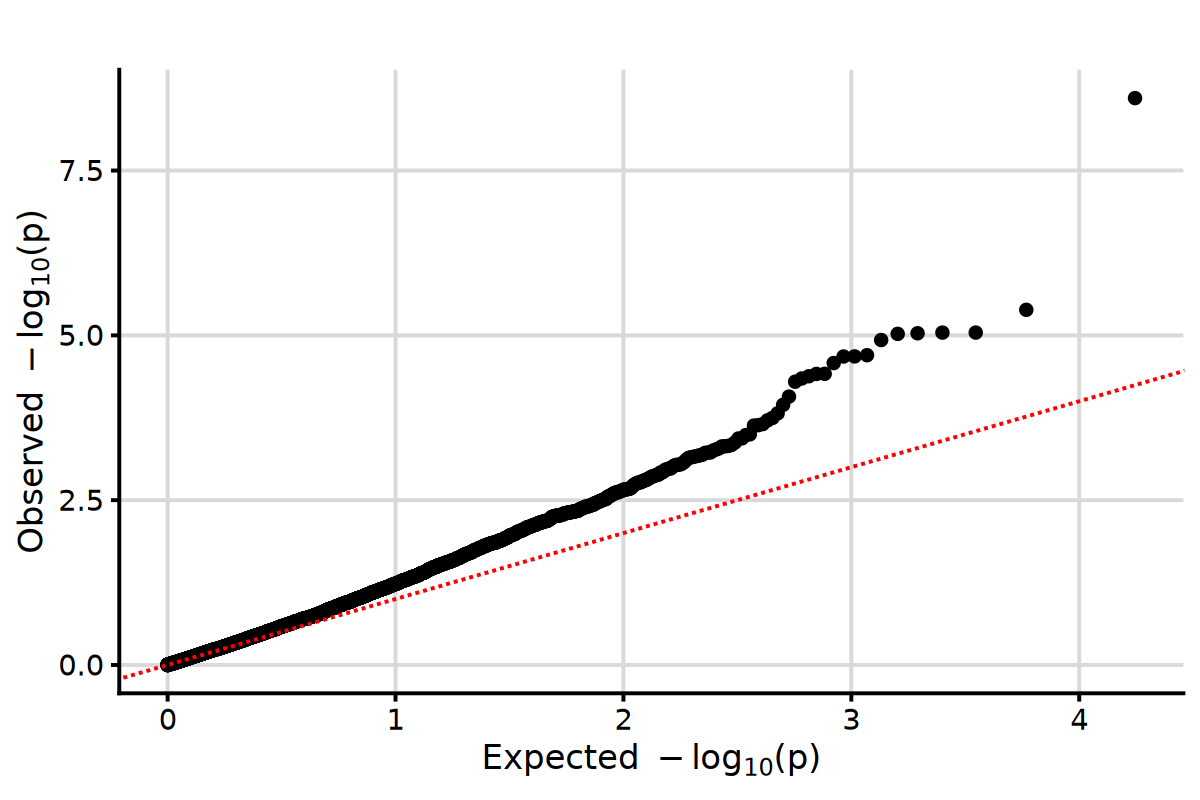

In [43]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
# Create a QQ plot
observed_pvals <- sort(p_values)
expected_pvals <- -log10(ppoints(length(p_values)))  # Expected p-values under uniform distribution

# QQ plot using ggplot2
p = ggplot(data = data.frame(observed = -log10(observed_pvals), expected = expected_pvals), aes(x = expected, y = observed)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "",
       x = expression(paste("Expected " -log[10], "(p)")),
       y = expression(paste("Observed " -log[10], "(p)"))) +
  THEME + background_grid()
p

In [44]:
width=6
height=4

path = paste(output_path, 'sex_qqplot', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/sex_qqplot..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”
